# EuroSAT Dataset Applying Custom CNN with SEBlock Attention Module + Grad-CAM++

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


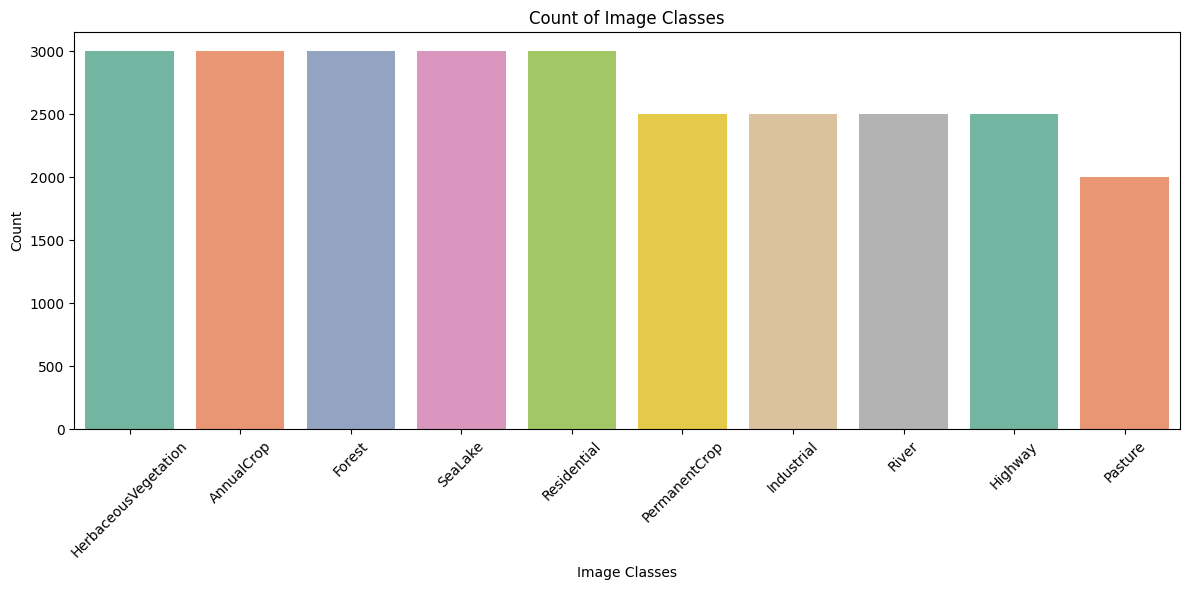

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

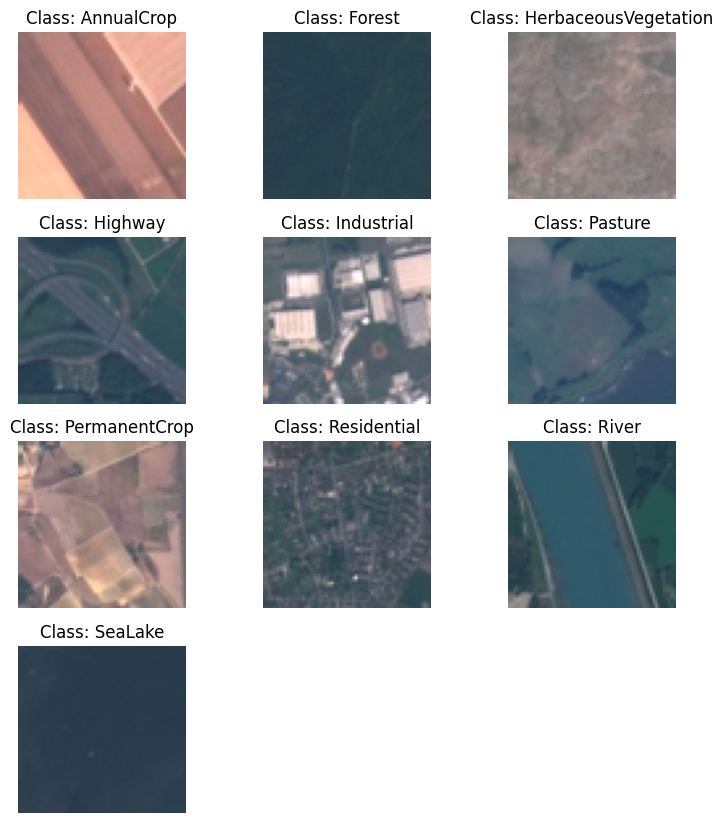

In [6]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [7]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [8]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [9]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

label mapping

In [10]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert('RGB')

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)




In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])


    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

In [16]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)       # [B, C]
        y = self.fc(y).view(b, c, 1, 1)              # [B, C, 1, 1]
        return x * y.expand_as(x)

### Convolutional Neural Netwirk (G7CNN)

In [17]:

class G7CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G7CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # → 32 x 224 x 224
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32 x 112 x 112
            
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # → 64 x 112 x 112
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 64 x 56 x 56
            

            # Block 3
            nn.Conv2d(64, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.Conv2d(84, 84, kernel_size=3, stride=1, padding=1),  # → 84 x 56 x 56
            nn.BatchNorm2d(84),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 84 x 28 x 28
            SEBlock(84),

            # Block 4
            nn.Conv2d(84, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # → 128 x 28 x 28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 128 x 14 x 14
            SEBlock(128),
            
            # Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # → 256 x 14 x 14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 256 x 7 x 7
            SEBlock(256),

        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # → 256 x 1 x 1

        self.classifier = nn.Sequential(
            nn.Flatten(),                        # → 256
            nn.Linear(256, 256),                 # → 256
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)          # → num_classes
        )

    def forward(self, x):
        x = self.conv_block(x)     # → 512 x 7 x 7
        x = self.global_pool(x)    # → 512 x 1 x 1
        x = self.classifier(x)     # → num_classes
        return x


In [18]:
checkpoint = torch.load('/kaggle/input/cnn-seblock-attention-model/pytorch/default/1/cnn-with-attention-modules/seblock/model-seblock.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_weight', 'optimizer_state'])


In [19]:

total_class = 10
learning_rate = 0.0001

model = G7CNN(num_classes=total_class)
model = model.to(device)
model.load_state_dict(checkpoint['model_weight'],strict=False)
model.eval()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

### Evaluation

In [20]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = "/kaggle/input/cnn-seblock-attention-model/pytorch/default/1/cnn-with-attention-modules/seblock/model-seblock.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 94) - Validation Loss: 0.070, Validation Accuracy: 0.981


In [21]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.981
Test Time: 5.81 seconds ---> 0.10 minutes


### Class Accuracy

In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       450
           1       1.00      1.00      1.00       450
           2       0.97      0.95      0.96       450
           3       0.99      0.98      0.99       375
           4       0.98      0.99      0.99       375
           5       0.95      0.98      0.96       300
           6       0.96      0.96      0.96       375
           7       1.00      0.99      0.99       450
           8       0.98      0.99      0.99       375
           9       1.00      0.99      0.99       450

    accuracy                           0.98      4050
   macro avg       0.98      0.98      0.98      4050
weighted avg       0.98      0.98      0.98      4050

Class 0 Accuracy: 0.980
Class 1 Accuracy: 0.998
Class 2 Accuracy: 0.947
Class 3 Accuracy: 0.976
Class 4 Accuracy: 0.997
Class 5 Accuracy: 0.983
Class 6 Accuracy: 0.968
Class 7 Accuracy: 0.987
Class 8 Accuracy: 0.992
Cl

### Confusion Matrix

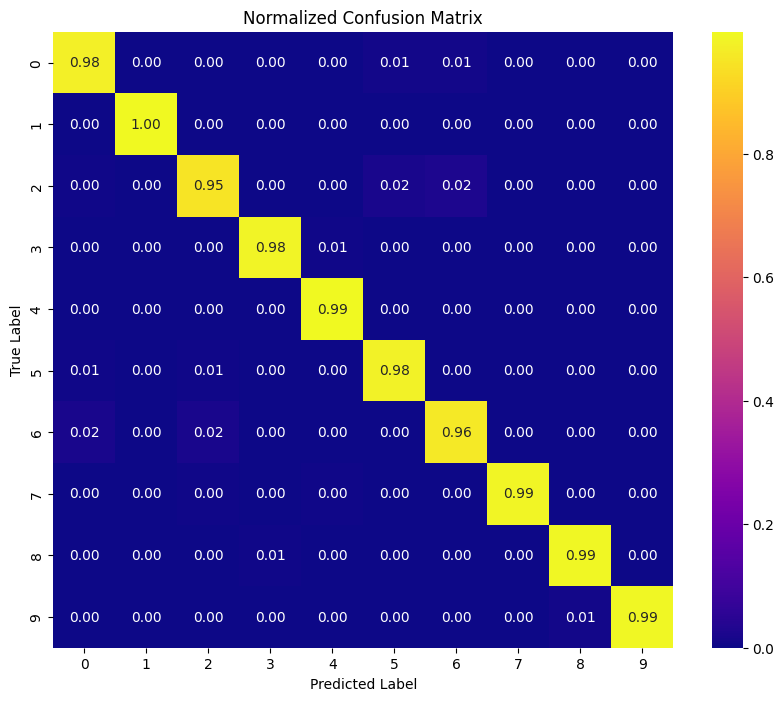

In [23]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC, ROC Curve

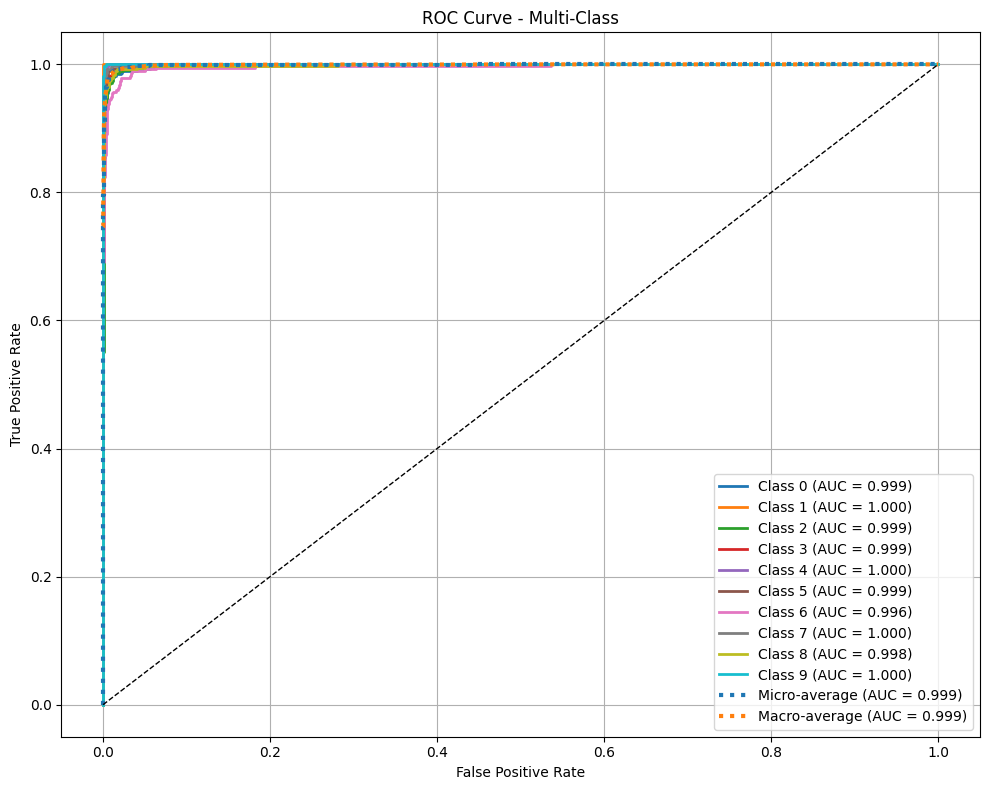

In [24]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### GradCAM++

In [25]:
class GradCAMPP:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_full_backward_hook(backward_hook)

        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        input_tensor.requires_grad_()

        # Forward + backward
        output = self.model(input_tensor)
        self.model.zero_grad()
        class_score = output[:, target_class]
        class_score.backward(retain_graph=True)

        gradients = self.gradients         # dY/dA
        activations = self.activations     # A

        # Grad-CAM++ weights (from paper)
        grads_power_2 = gradients ** 2
        grads_power_3 = gradients ** 3
        numerator = grads_power_2
        denominator = 2 * grads_power_2 + torch.sum(activations * grads_power_3, dim=(2, 3), keepdim=True)
        denominator = torch.where(denominator != 0.0, denominator, torch.ones_like(denominator))

        alpha = numerator / denominator
        positive_gradients = F.relu(class_score.exp().unsqueeze(-1).unsqueeze(-1) * gradients)
        weights = torch.sum(alpha * positive_gradients, dim=(2, 3), keepdim=True)

        cam = torch.sum(weights * activations, dim=1)
        cam = F.relu(cam)

        # Normalize CAM
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam -= np.min(cam)
        cam /= (np.max(cam) + 1e-8)
        return cam

In [26]:
def show_gradcampp(
    model, dataloader, device, target_layer, classes,
    save_path="gradcampp_one_per_class.png",
):
    model.eval()
    gradcampp = GradCAMPP(model, target_layer)

    class_to_sample = {}

    print("Collecting one sample per classes...")

    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            label_idx = labels[i].item()
            class_name = classes[label_idx]
            if class_name not in class_to_sample:
                class_to_sample[class_name] = (inputs[i].cpu(), label_idx)
            if len(class_to_sample) == len(classes):
                break
        if len(class_to_sample) == len(classes):
            break

    if len(class_to_sample) < len(classes):
        print("Warning: Not all classes found in the dataloader!")

    sorted_classes = sorted(class_to_sample.keys())
    samples = [class_to_sample[cls] for cls in sorted_classes]

    plt.figure(figsize=(12, len(samples) * 3))

    for idx, (input_tensor, label_idx) in enumerate(samples):
        input_tensor = input_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        cam = gradcampp.generate_cam(input_tensor, pred_class).squeeze()
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = np.maximum(cam, 0)
        cam_max = cam.max()
        if cam_max > 0:
            cam /= cam_max

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

        # No denormalization needed, image is in [0,1]
        img_np = input_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)

        img_uint8 = (img_np * 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)

        overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)

        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        plt.subplot(len(samples), 2, 2 * idx + 1)
        plt.imshow(img_np)
        plt.title(f"Original\nGT: {sorted_classes[idx]}")
        plt.axis('off')

        plt.subplot(len(samples), 2, 2 * idx + 2)
        plt.imshow(overlay_rgb)
        plt.title(f"Grad-CAM++\nPred: {classes[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    gradcampp.remove_hooks()

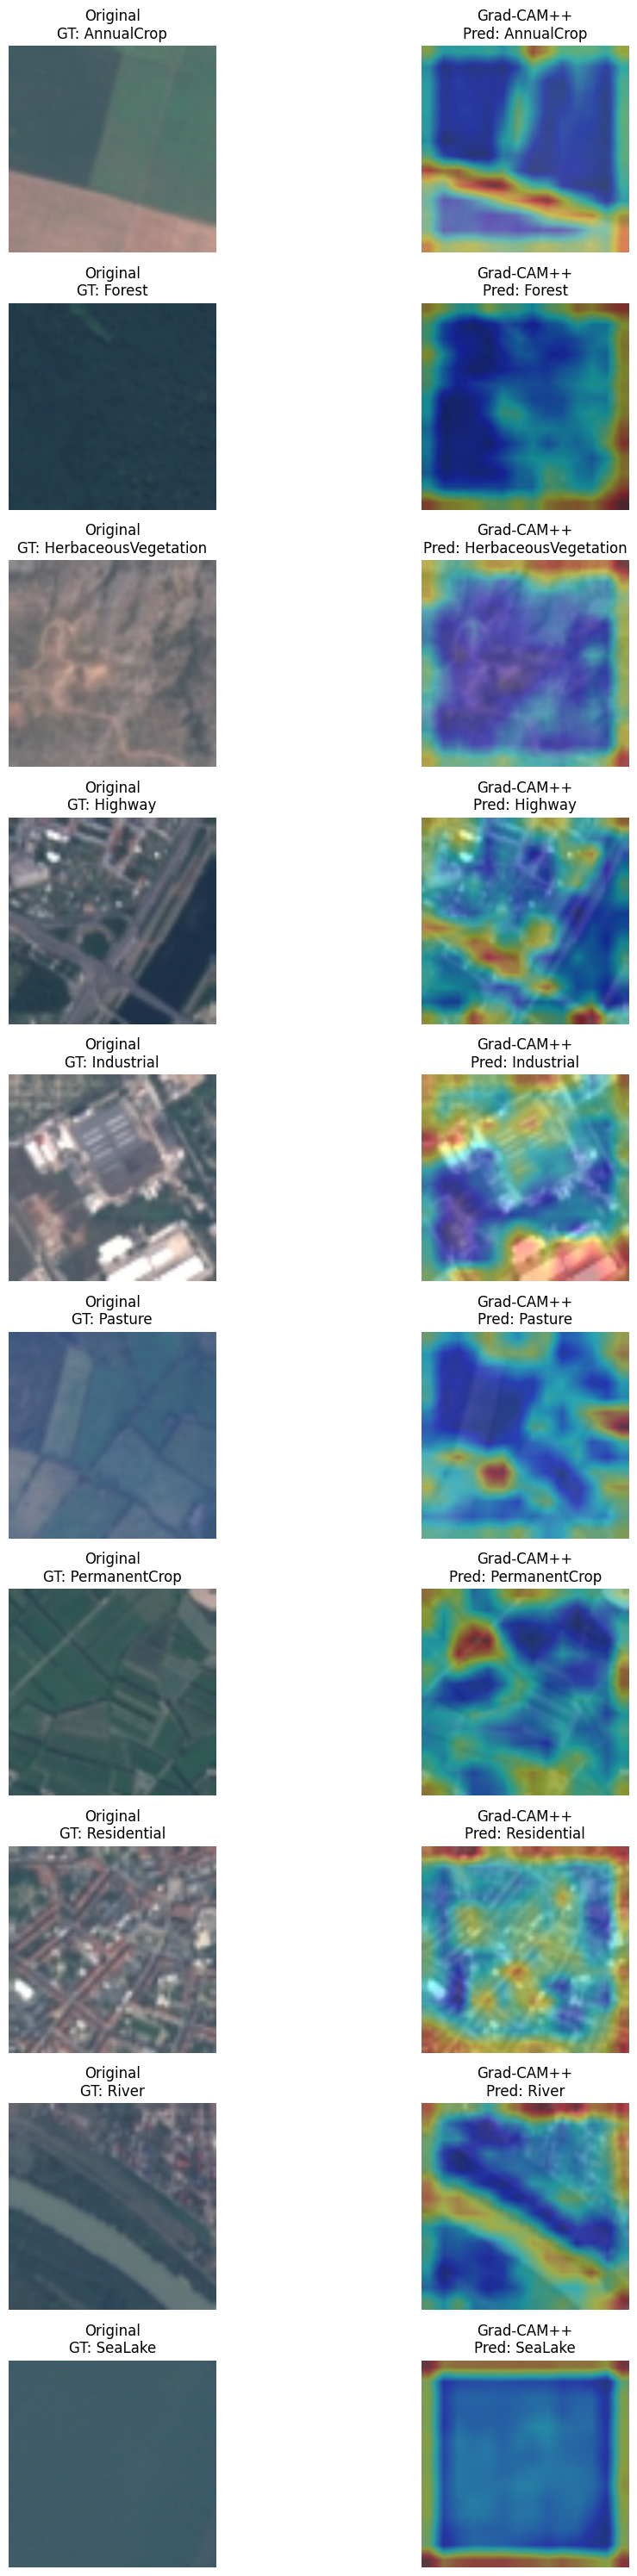

In [27]:
classes = sorted(label_map.keys())

show_gradcampp(
    model=model,
    dataloader=dataloader_valid_dataset,
    device=device,
    target_layer=model.conv_block[32],  # your correct layer
    classes=classes
)